In [4]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from __future__ import print_function, absolute_import, division

In [6]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available()

1.13.1


True

## The Game to Learn From

In [7]:
from GomokuBoard import GomokuBoard
from HeuristicPolicy import HeuristicGomokuPolicy
from Heuristics import Heuristics
from GomokuTools import GomokuTools as gt
from GomokuData import data_from_game
stones=gt.string_to_stones('e10g8g5f5f6e7f7f8e8g9h10d9g10f10h8h9i9g7e9j8h11i12e11e12g11f11f12e13g13h14i10g14j9k8i8k4i7')
heuristics = Heuristics(kappa=3.0)
stones = stones[:-5]
print(stones)

[('E', 10), ('G', 8), ('G', 5), ('F', 5), ('F', 6), ('E', 7), ('F', 7), ('F', 8), ('E', 8), ('G', 9), ('H', 10), ('D', 9), ('G', 10), ('F', 10), ('H', 8), ('H', 9), ('I', 9), ('G', 7), ('E', 9), ('J', 8), ('H', 11), ('I', 12), ('E', 11), ('E', 12), ('G', 11), ('F', 11), ('F', 12), ('E', 13), ('G', 13), ('H', 14), ('I', 10), ('G', 14)]


In [8]:
board_size=20

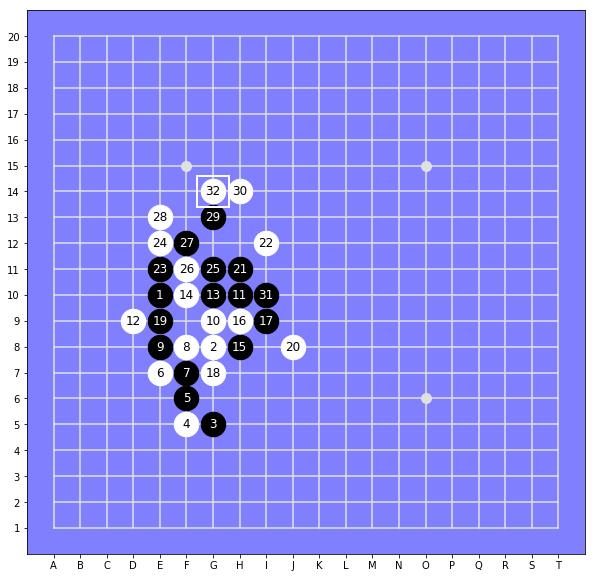

In [9]:
board = GomokuBoard(N=board_size, disp_width=10, heuristics=heuristics, stones=stones)
board.display()

In [10]:
from GomokuData import create_sample, to_matrix12
s = create_sample(board.stones, 20, 0)
to_matrix12(s)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 1, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0,

---
## The Deep Q-Function
This function is designed to integrate into the estimator training

In [11]:
def conv_gomoku(board_size, features, feature_columns, options):

    N = board_size
    
    layout = options['layout']
    
    feature_columns = [num('state', shape=((N+2)*(N+2)*2))]

    input_layer = tf.feature_column.input_layer( 
        features, feature_columns=feature_columns)

    layer = tf.reshape(input_layer, [-1, N+2, N+2, 2], name='reshape_input') 
   
    for filters, kernel in np.reshape(layout, [-1,2]):
        layer = tf.layers.conv2d(inputs=layer, filters=filters, 
                                 kernel_size=[kernel, kernel], strides=[1,1], 
                                 padding='SAME')
        
        # Exotic! Let the network learn efficient activation functions at each layer
        beta_l = tf.Variable(-0.5),
        beta_r = tf.Variable(0.5)
        layer = layer * (layer - beta_l) * (layer - beta_r)
        
    layer = tf.layers.conv2d(inputs=layer, filters=1, 
                              kernel_size=[kernel, kernel], strides=[1,1], 
                             padding='SAME')
    
    return layer

In [12]:
state = tf.reshape(tf.constant(s, dtype=tf.float32), [-1, 968])

In [13]:
from tensorflow.feature_column import numeric_column as num
features = {'state': [state] * 5}
feature_columns = [num('state', shape=((board_size+2)*(board_size+2)*2))]

In [14]:
layout=[128, 3, 128, 3, 128, 3, 64, 3, 64, 3, 16, 3]
options={'layout': layout, 'learning_rate': 1e-4}

In [15]:
qf = conv_gomoku(20, features, feature_columns, options)
qf

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.


<tf.Tensor 'conv2d_6/BiasAdd:0' shape=(5, 22, 22, 1) dtype=float32>

--- 
## Masking the edges

In [16]:
mask = np.ones([22, 22], dtype=int)
mask[0] = 0
mask[21] = 0
mask[:,0]=0
mask[:,21]=0
mask = tf.constant(mask, dtype=tf.float32)
mask = tf.expand_dims(mask,-1)
mask

<tf.Tensor 'ExpandDims:0' shape=(22, 22, 1) dtype=float32>

In [17]:
qfm = qf * mask
qfm

<tf.Tensor 'mul_12:0' shape=(5, 22, 22, 1) dtype=float32>

In [18]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    q, m, qm = sess.run([qf, mask, qfm])

In [19]:
q.shape, m.shape, qm.shape

((5, 22, 22, 1), (22, 22, 1), (5, 22, 22, 1))

In [20]:
qvalues = np.rollaxis(qm[0], 2, 0)[0]

In [21]:
qvalues[:2], qvalues.shape

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.39598594e-05, 3.40957304e-05, 5.00902861e-05,
         2.89241325e-05, 1.40736020e-05, 1.74014149e-05, 1.67447106e-05,
         1.24594080e-05, 1.20944542e-05, 1.49873840e-05, 1.52694483e-05,
         1.59229421e-05, 1.52967259e-05, 1.38442665e-05, 1.19242741e-05,
         1.48978406e-05, 1.33893764e-05, 3.19697974e-05, 2.90816733e-05,
         1.32574223e-05, 0.00000000e+00]], dtype=float32), (22, 22))

## The Labels From Heuristics

In [22]:
from QFunction import heuristic_QF
from GomokuData import wrap_sample

In [23]:
policy = HeuristicGomokuPolicy(board, 2)
hqf, dval = heuristic_QF(board, policy)

In [24]:
hqf = wrap_sample(hqf, 0.0)

In [25]:
hqf[0:2], hqf.shape

(array([[  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  0.        , -73.93027488, -73.93027488, -73.93027488,
         -73.93027488, -73.93027488, -73.93027488, -73.93027488,
         -73.93027488, -73.93027488, -73.93027488, -73.93027488,
         -73.93027488, -73.93027488, -73.93027488, -73.93027488,
         -73.93027488, -73.93027488, -73.93027488, -73.93027488,
         -73.93027488,   0.        ]]), (22, 22))

In [26]:
hqf = hqf/100.0 # helps converge faster
hqf.shape

(22, 22)

## Learning to QValuate a Single Situation
This is just to verify that the exotic choices in the hypotheses still provide good convergence.

In [27]:
s5 = [s]*5
hqf5 = np.array([hqf]*5)
hqf5 = np.expand_dims(hqf5,-1)
hqf5.shape, np.shape(s5)

((5, 22, 22, 1), (5, 22, 22, 2))

In [28]:
def create_model(inputs, labels, options):
    """
    samples and labels must be ndarrays of shape (N,22,22,2) and (N,22,22,1) resp.
    """

    learning_rate=options['learning_rate']
    
    mask = np.ones([22, 22], dtype=int)
    mask[0] = 0
    mask[21] = 0
    mask[:,0]=0
    mask[:,21]=0
    mask = tf.constant(mask, dtype=tf.float32)
    mask = tf.expand_dims(mask,-1)
    
    inputs = [tf.reshape(tf.constant(sample, dtype=tf.float32), [-1, 968]) 
              for sample in inputs]
    
    from tensorflow.feature_column import numeric_column as num
    feature_columns = [num('state', shape=((board_size+2)*(board_size+2)*2))]
    
    #inputs = {'state': [ sample for sample in inputs ]}
    features = {'state': inputs}
    qf = conv_gomoku(20, features, feature_columns, options)    
    
    labels = tf.constant(labels, dtype=tf.float32)
    loss = tf.losses.mean_squared_error(labels, qf * mask)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    
    
    return qf * 100.0, optimizer, loss

In [29]:
qf, opt, loss = create_model(s5, hqf5 / 100.0, options)

In [30]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    for i in range(3001):
        _ = session.run(opt)
        if i % 200 == 0:
            l = session.run(loss)
            l_t = session.run(loss)
            print(l, l_t)
    res=session.run(100.0 * qf)

4.0887808e-05 4.0887808e-05
2.6175837e-07 2.6175837e-07
2.3705144e-07 2.3705144e-07
2.1640508e-07 2.1640508e-07
1.9704213e-07 1.9704213e-07
1.727168e-07 1.727168e-07
1.4275555e-07 1.4275555e-07
1.15027106e-07 1.15027106e-07
9.041663e-08 9.041663e-08
6.976835e-08 6.976835e-08
5.499212e-08 5.499212e-08
4.513788e-08 4.513788e-08
3.8307643e-08 3.8307643e-08
3.312723e-08 3.312723e-08
2.8725342e-08 2.8725342e-08
2.4409813e-08 2.4409813e-08


In [31]:
np.rollaxis(res[0], 2, 0)[0][8].astype(int)

array([-59, -74, -74, -75, -72, -72, -36, -74, -47, -72, -69, -74, -71,
       -76, -74, -74, -74, -74, -73, -73, -73, -55])

Note, that the first and last field in this 8th row are effectively beyond the border and don't contribute to the loss function.

In [32]:
(hqf*100.0)[8].astype(int)

array([  0, -73, -73, -73, -73, -73, -33, -73, -46, -73, -73, -73, -73,
       -73, -73, -73, -73, -73, -73, -73, -73,   0])

# Learning from 8 different  samples

In [33]:
from GomokuData import create_samples_and_qvalues

In [34]:
states, qvalues = create_samples_and_qvalues(board, heuristics)

In [35]:
states.shape, qvalues.shape

((8, 22, 22, 2), (8, 22, 22, 1))

In [36]:
qf, opt, loss = create_model(states, qvalues / 100.0, options)

In [37]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    for i in range(5001):
        _ = session.run(opt)
        if i % 500 == 0:
            l = session.run(loss)
            l_t = session.run(loss)
            print(l, l_t)
    res=session.run(qf)

0.5538648 0.5538648
0.1045365 0.1045365
0.101267055 0.101267055
0.100856125 0.100856125
0.10048717 0.10048717
0.100234576 0.100234576
0.099853076 0.099853076
0.09902189 0.09902189
0.09865094 0.09865094
0.09851635 0.09851635
0.09846662 0.09846662


All learned Q-Values are within a tolerance of $\pm 10$.

In [38]:
tolerance = 10.0
for i in range(8):
    deepq = np.rollaxis(res[i], 2, 0)[0][1:-1].T[1:-1].T
    qvals = np.rollaxis(qvalues[i], 2, 0)[0][1:-1].T[1:-1].T
    print ((deepq - qvals > -tolerance).all() & (deepq - qvals < tolerance).all())

True
True
True
True
True
True
True
True


## Learn From the Game's Entire History

In [45]:
from copy import deepcopy
from GomokuData import data_from_game

In [46]:
states, qvalues = data_from_game(deepcopy(board), policy, heuristics)

In [47]:
states.shape, qvalues.shape

((192, 22, 22, 2), (192, 22, 22, 1))

In [48]:
options['learning_rate'] = 1e-4
qf, opt, loss = create_model(states, qvalues / 100.0, options)

In [49]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    for i in range(2001):
        _ = session.run(opt)
        if i % 1000 == 0:
            l = session.run(loss)
            l_t = session.run(loss)
            print(l, l_t)
    res=session.run(qf)

1.4853274 1.4853274
0.75400645 0.75400645
0.614086 0.614086


In [50]:
for i in range(8):
    deepq = np.rollaxis(res[i], 2, 0)[0][1:-1].T[1:-1].T
    qvals = np.rollaxis(qvalues[i], 2, 0)[0][1:-1].T[1:-1].T
    print(max(np.max(deepq-qvals), -np.min(deepq-qvals)))

69.37782703738182
74.46426807742088
67.42985187869044
70.99745594363185
78.46836506228416
75.08716236453026
62.32564960818257
64.97024952273335


That's not going to work at all. Let's look at the sixth row of all the 24 different games states. We can see that the network is particularly bad at critical states. 

In [87]:
for idx in range(0, 192, 8):
    default_value = qvalues[idx][0][0]
    deepq = np.rollaxis(res[idx], 2, 0)[0][1:-1].T[1:-1].T
    qvals = np.rollaxis(qvalues[idx], 2, 0)[0][1:-1].T[1:-1].T
    print("Default: %s" % default_value)
    print("Differences: %s" % (deepq - qvals).astype(int)[6])
    print("Heuristics: %s" % qvals.astype(int)[6])

Default: [-56.78407288]
Differences: [-21 -13 -17  -3 -43  -9 -54 -21 -13 -19 -20 -35 -43 -32 -30 -38 -32 -35
 -30 -36]
Heuristics: [-56 -56 -56 -56 -26 -56 -29 -56 -56 -56 -56 -56 -56 -56 -56 -56 -56 -56
 -56 -56]
Default: [-200.]
Differences: [  73   62   61   56   57   57   55 -159   56   57   57   60   71   90
  106  103  110  107  112  106]
Heuristics: [-200 -200 -200 -200 -200 -200 -200   13 -200 -200 -200 -200 -200 -200
 -200 -200 -200 -200 -200 -200]
Default: [-43.24866486]
Differences: [-29 -17 -13  -1 -44  -8 -31 -33 -11  -9   6   6 -26 -40 -43 -51 -46 -49
 -43 -50]
Heuristics: [-43 -43 -43 -43 -12 -43 -23 -29 -43 -43 -43 -43 -43 -43 -43 -43 -43 -43
 -43 -43]
Default: [-200.]
Differences: [ 76  67  62  62  60  60  57  56  55  56  55  60  71  91 106 103 110 107
 112 106]
Heuristics: [-200 -200 -200 -200 -200 -200 -200 -200 -200 -200 -200 -200 -200 -200
 -200 -200 -200 -200 -200 -200]
Default: [-25.61275673]
Differences: [-37 -14  -6   5  10  20  -7   7  -1 -13 -13 -12 -42 -58 

In [84]:
from GomokuData import to_matrix_xo
def to_matrix_xo(sample):
    if np.sum(to_matrix12(sample)>0) % 2 == 0:
        symbols = ['. ', 'x ', 'o ']
    else:
        symbols = ['. ', 'o ', 'x ']
    im12 = to_matrix12(sample)
    return "\n".join(["".join([symbols[c] for c in im12[r]]) for r in range(20) ])

In [85]:
print(to_matrix_xo(states[0]))

. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . o . . . . . . . . . . . . 
. . . . o . x . . . . . . . . . . . . . 
. . . . o x . . o . . . . . . . . . . . 
. . . . x o x x . . . . . . . . . . . . 
. . . . x o x x . . . . . . . . . . . . 
. . . o x . o o x . . . . . . . . . . . 
. . . . x o o x . o . . . . . . . . . . 
. . . . o x o . . . . . . . . . . . . . 
. . . . . x . . . . . . . . . . . . . . 
. . . . . o x . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 


In [86]:
print(to_matrix_xo(states[8]))

. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . o . x . . . . . . . . . . . . . 
. . . . o x . . o . . . . . . . . . . . 
. . . . x o x x . . . . . . . . . . . . 
. . . . x o x x . . . . . . . . . . . . 
. . . o x . o o x . . . . . . . . . . . 
. . . . x o o x . o . . . . . . . . . . 
. . . . o x o . . . . . . . . . . . . . 
. . . . . x . . . . . . . . . . . . . . 
. . . . . o x . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . 


---
## Learning A-Values Instead
The reason is obviously the massive variance of the default QValue. QValues are hard to learn. Let's try to learn Advantage values instead. In our case we can easily identify the default value used in the heuristic QFunction, since the beyond-border fields are filled by that value. Subtracting that default value from all fields provides a pretty good estimate for an advantage function.

In [115]:
for i in range(192):
    avalues[i] = qvalues[i]-qvalues[i][0][0][0]

In [116]:
options['learning_rate'] = 1e-4
qf, opt, loss = create_model(states, avalues / 100.0, options)

In [117]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    for i in range(10001):
        _ = session.run(opt)
        if i % 100 == 0:
            l = session.run(loss)
            l_t = session.run(loss)
            print(l, l_t)
    res=session.run(qf)

0.005222794 0.005222794
0.004861028 0.004861028
0.004698552 0.004698552
0.0046457876 0.0046457876
0.004399874 0.004399874
0.004284504 0.004284504
0.0042349016 0.0042349016
0.0041632103 0.0041632103
0.0039852955 0.0039852955
0.0037320948 0.0037320948
0.003474875 0.003474875
0.0031527232 0.0031527232
0.0026838558 0.0026838558
0.0020495048 0.0020495048
0.0015220487 0.0015220487
0.0012394683 0.0012394683
0.0010710674 0.0010710674
0.00096288545 0.00096288545
0.00088214217 0.00088214217
0.00081774354 0.00081774354
0.0007627838 0.0007627838
0.0007147585 0.0007147585
0.0006743056 0.0006743056
0.00063496607 0.00063496607
0.00059598073 0.00059598073
0.0005608407 0.0005608407
0.00052951364 0.00052951364
0.0005011643 0.0005011643
0.00049159053 0.00049159053
0.00044780987 0.00044780987
0.00042431857 0.00042431857
0.00040229445 0.00040229445
0.00037926005 0.00037926005
0.00035993487 0.00035993487
0.00034197397 0.00034197397
0.00032527017 0.00032527017
0.00030980635 0.00030980635
0.00029390372 0.0002

In [118]:
for idx in range(0, 192, 8):
    default_value = qvalues[idx][0][0]
    deepq = np.rollaxis(res[idx], 2, 0)[0][1:-1].T[1:-1].T + default_value
    qvals = np.rollaxis(qvalues[idx], 2, 0)[0][1:-1].T[1:-1].T
    print("Default: %s" % default_value)
    print("Differences: %s" % (deepq - qvals).astype(int)[6])
    print("Heuristics: %s" % qvals.astype(int)[6])

Default: [-56.78407288]
Differences: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
Heuristics: [-56 -56 -56 -56 -26 -56 -29 -56 -56 -56 -56 -56 -56 -56 -56 -56 -56 -56
 -56 -56]
Default: [-200.]
Differences: [ 0  1  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0]
Heuristics: [-200 -200 -200 -200 -200 -200 -200   13 -200 -200 -200 -200 -200 -200
 -200 -200 -200 -200 -200 -200]
Default: [-43.24866486]
Differences: [ 0  0  0  0  0 -1  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
Heuristics: [-43 -43 -43 -43 -12 -43 -23 -29 -43 -43 -43 -43 -43 -43 -43 -43 -43 -43
 -43 -43]
Default: [-200.]
Differences: [ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
Heuristics: [-200 -200 -200 -200 -200 -200 -200 -200 -200 -200 -200 -200 -200 -200
 -200 -200 -200 -200 -200 -200]
Default: [-25.61275673]
Differences: [ 0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0]
Heuristics: [-25 -25 -25 -25 -25 -25   0 -25 -25 -25 -25 -25 -25 -25 -25 -25 -25 -25
 -25 -25]
Default: [-200.]
Differe

In [124]:
idx=32
default_value = qvalues[idx][0][0]
deepq = np.rollaxis(res[idx], 2, 0)[0][1:-1].T[1:-1].T + default_value
qvals = np.rollaxis(qvalues[idx], 2, 0)[0][1:-1].T[1:-1].T
deepq.astype(int)

array([[-25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25,
        -25, -25, -25, -25, -25, -25, -25],
       [-25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25,
        -25, -25, -25, -25, -25, -25, -25],
       [-25, -25, -25, -25, -26, -25, -25, -25, -25, -25, -25, -25, -25,
        -25, -25, -25, -25, -25, -25, -25],
       [-25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25, -25,
        -25, -25, -25, -25, -25, -25, -25],
       [-25, -25, -25, -25, -25, -25, -26, -25, -26, -25, -25, -25, -25,
        -25, -25, -25, -25, -25, -25, -25],
       [-25, -25, -25, -25, -25, -25, -25, -24, -25, -26, -26, -25, -25,
        -25, -25, -25, -25, -25, -25, -25],
       [-25, -24, -24, -25, -25, -24,   0, -26, -26, -25, -26, -25, -25,
        -25, -25, -25, -25, -25, -25, -25],
       [-25, -25, -25, -25, -30,   5, -26,  -5, -26, -24, -25, -25, -24,
        -25, -25, -25, -25, -25, -25, -25],
       [-25, -24, -24, -25, -25, -20,  -4,  -4, -25, -24, -25,  

---
### Summary
The advantage function can obviously be efficiently learned. The Q-Function is too hard to understand for any neural network.